# FOIL Project 4: Overcoming catastrophic forgetting in neural networks.

[This paper](https://arxiv.org/pdf/1612.00796.pdf), by James Kirkpatrick et al., studies the setting of continual learning, where an agent learns multiple tasks sequentially, i.e., accumulating knowledge for a new task/experience without having access to data from past tasks. In this setting, the phenomenon of catastrophic forgetting arises; the performance of the agent on past experiences significantly diminishes upon learning new tasks. The paper proposes the use of a regularization term to combat this problem. We suggest steering from the reinforcement learning experience and, instead, focus on supervised learning. Reproduce the results of Figure 2 (subfigures A + B) on the following datasets: PermutedMNIST (as in the paper) as well as RotatedMNIST (ten tasks of rotating MNIST, where task i is produced by a fixed rotation of 10(i − 1) degrees). Compare the results of the proposed regularization with naive L2 regularization and no regularization.

In [58]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

### Load the data:

Create three tasks of permuted MNIST

In [59]:
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

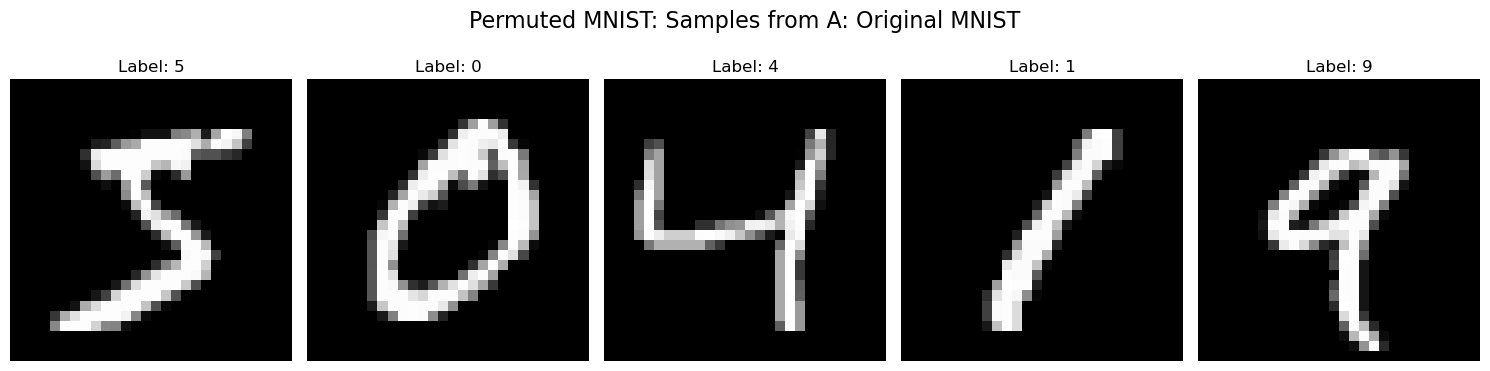

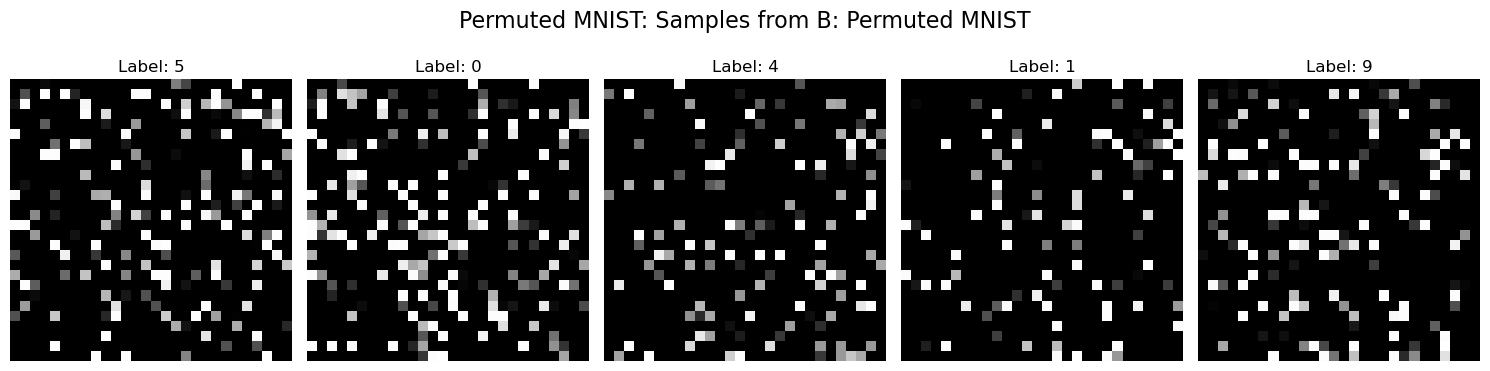

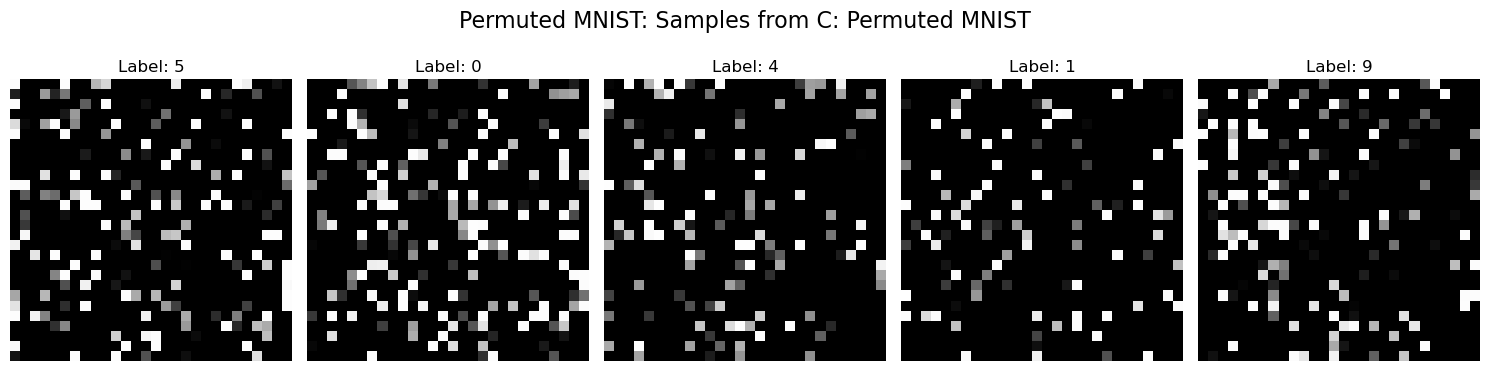

In [68]:
Task = namedtuple("Task", ["name", "train", "test"])

def create_permuted_mnist(task_id, seed=0):
    rng = np.random.RandomState(seed + task_id)
    perm = torch.tensor(rng.permutation(28 * 28), dtype=torch.long)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)[perm].view(1, 28, 28))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

seed = 42069
tasks = [Task(name="A: Original MNIST", train=mnist_train, test=mnist_test),
         Task(name="B: Permuted MNIST", train=create_permuted_mnist(1, seed)[0], test=create_permuted_mnist(1, seed)[1]),
         Task(name="C: Permuted MNIST", train=create_permuted_mnist(2, seed)[0], test=create_permuted_mnist(2, seed)[1])]

for task in tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Permuted MNIST: Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()


Create rotated MNIST datasets:

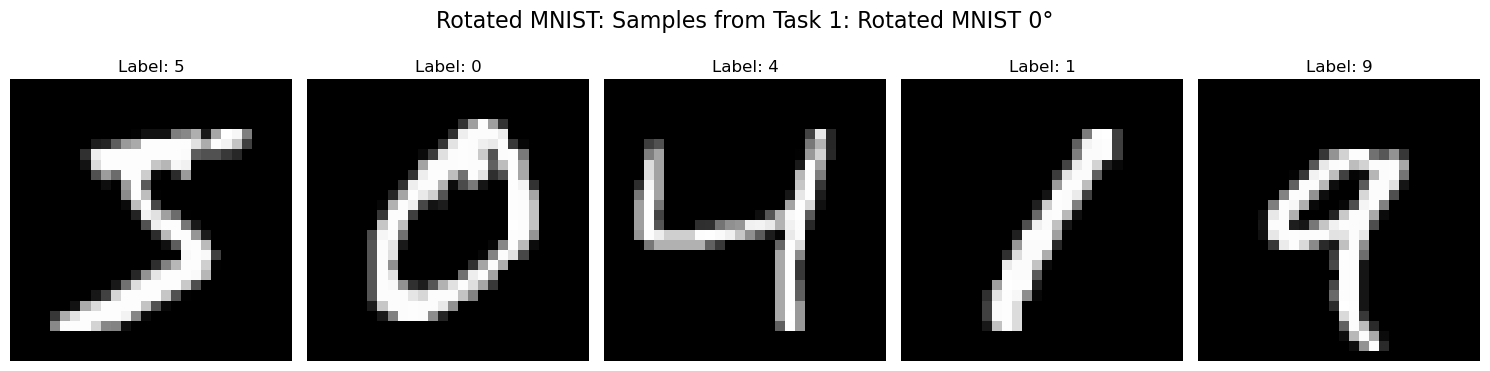

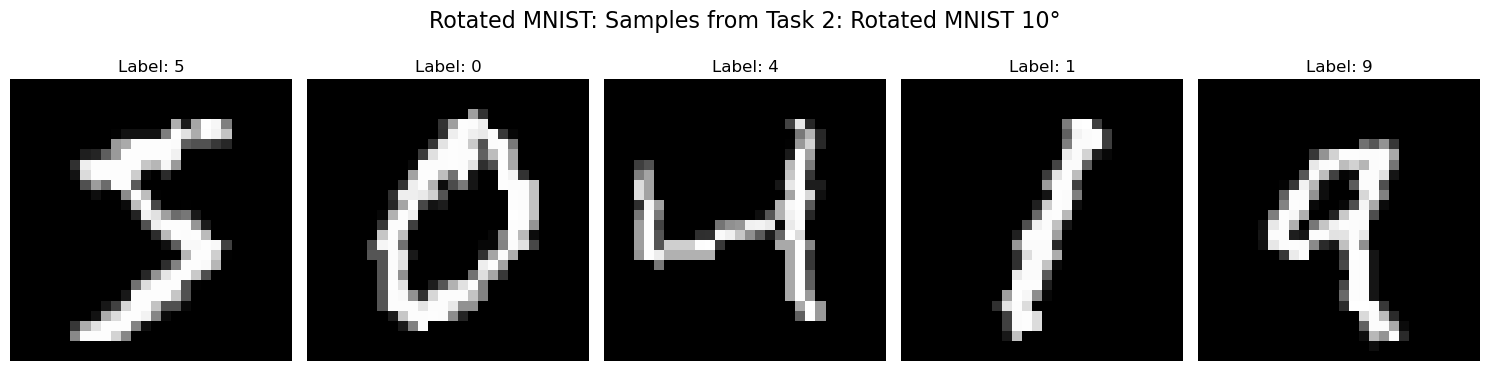

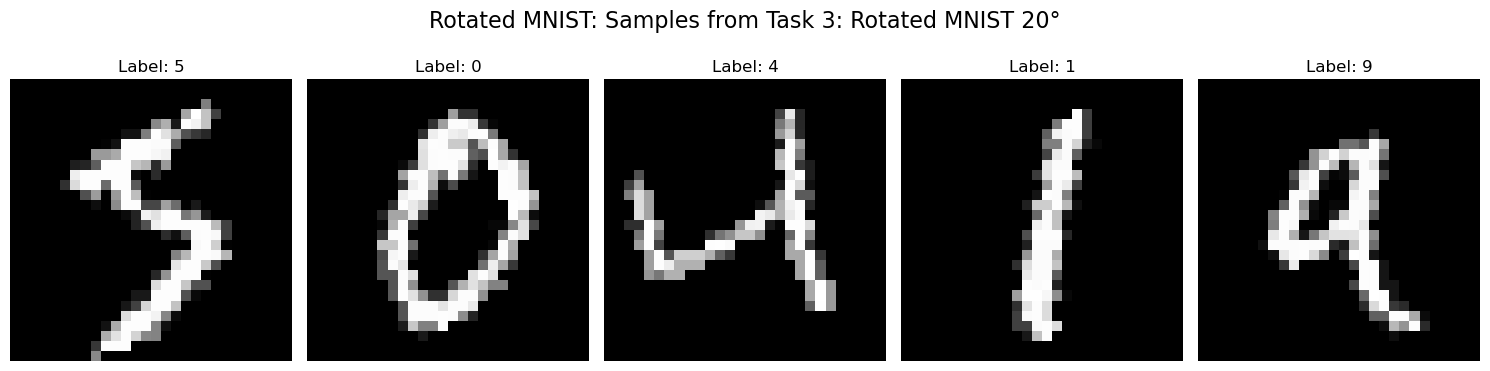

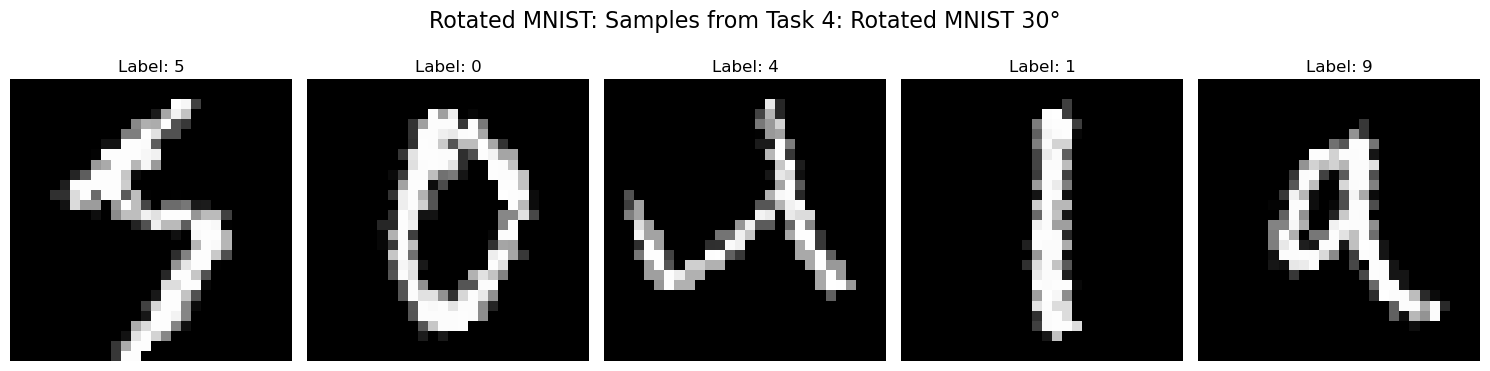

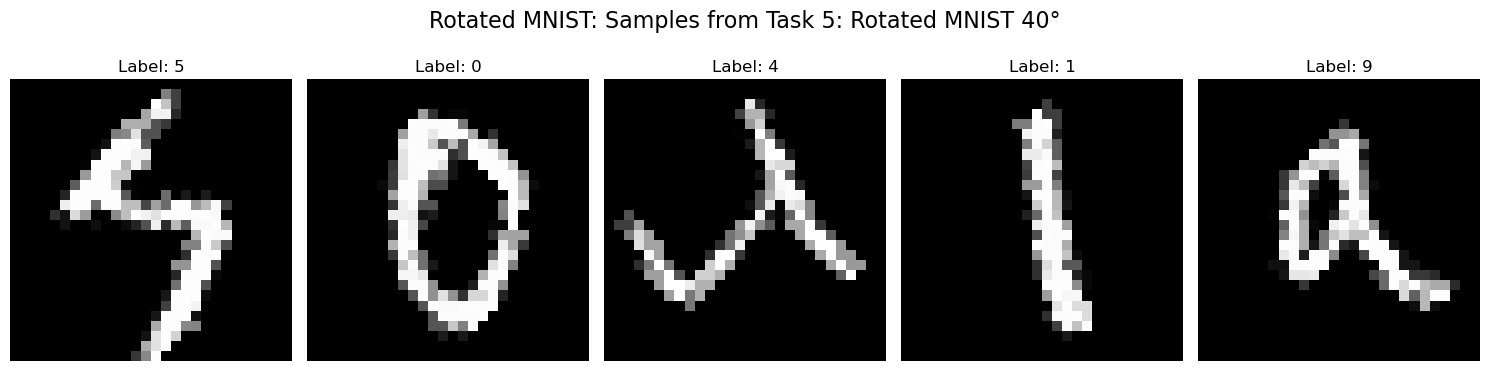

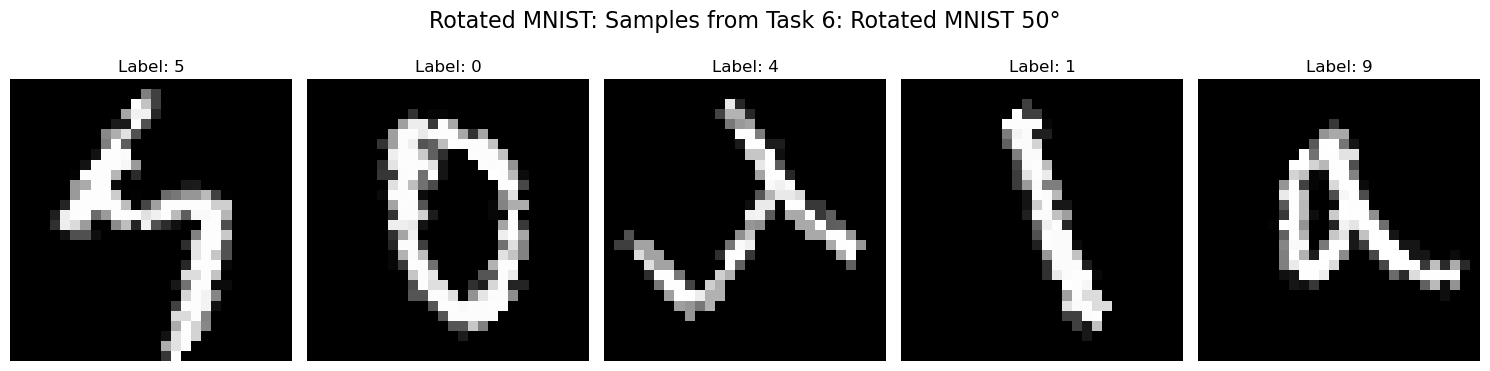

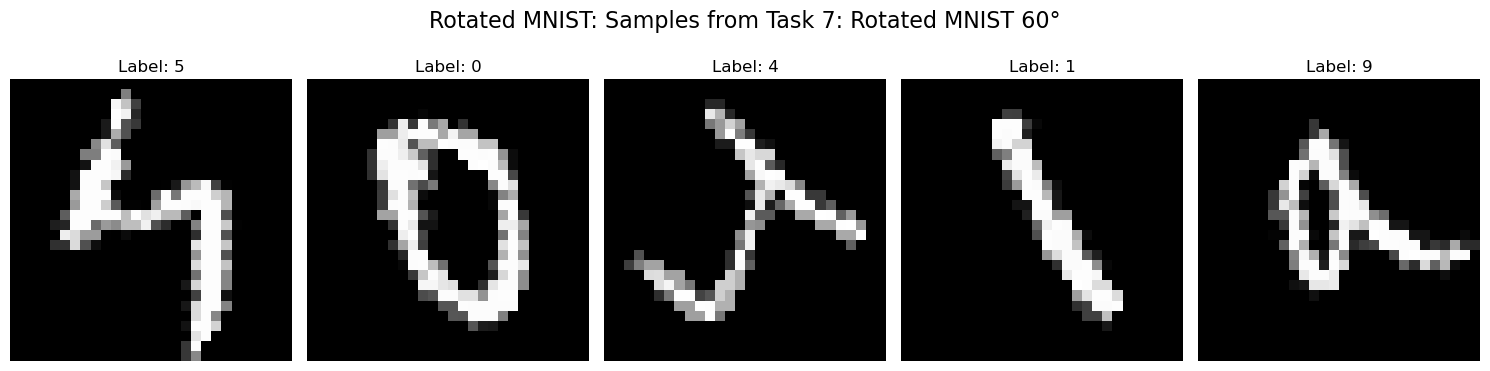

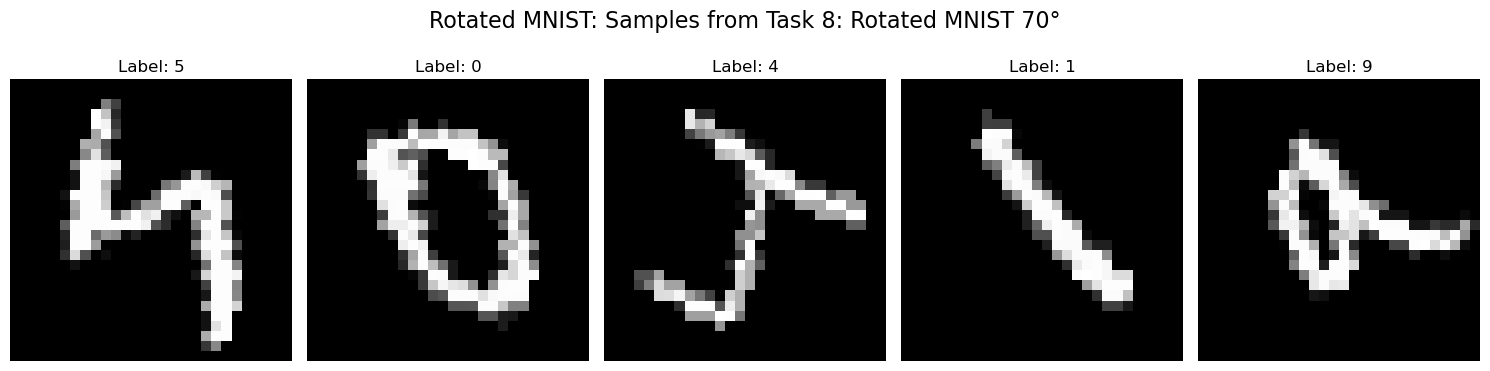

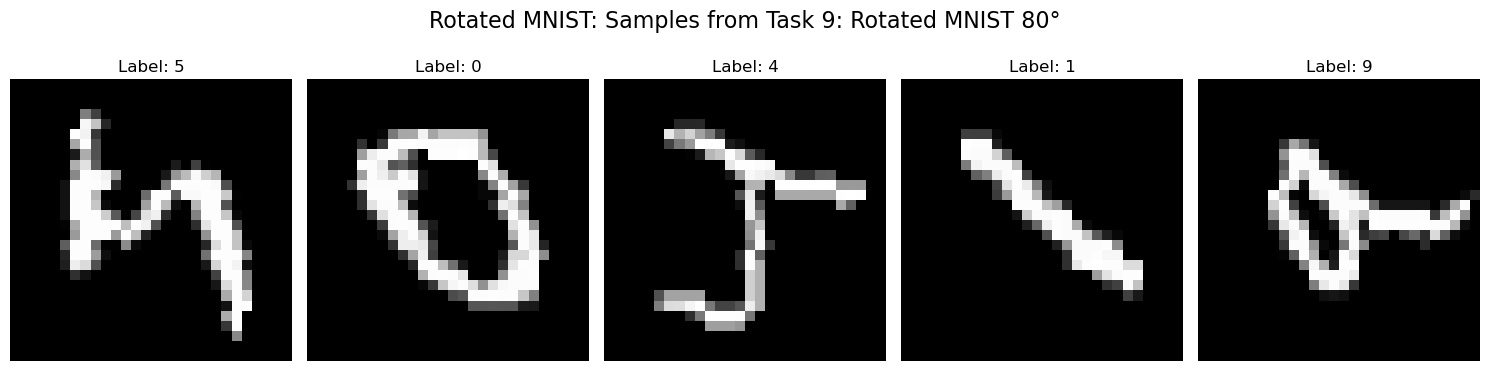

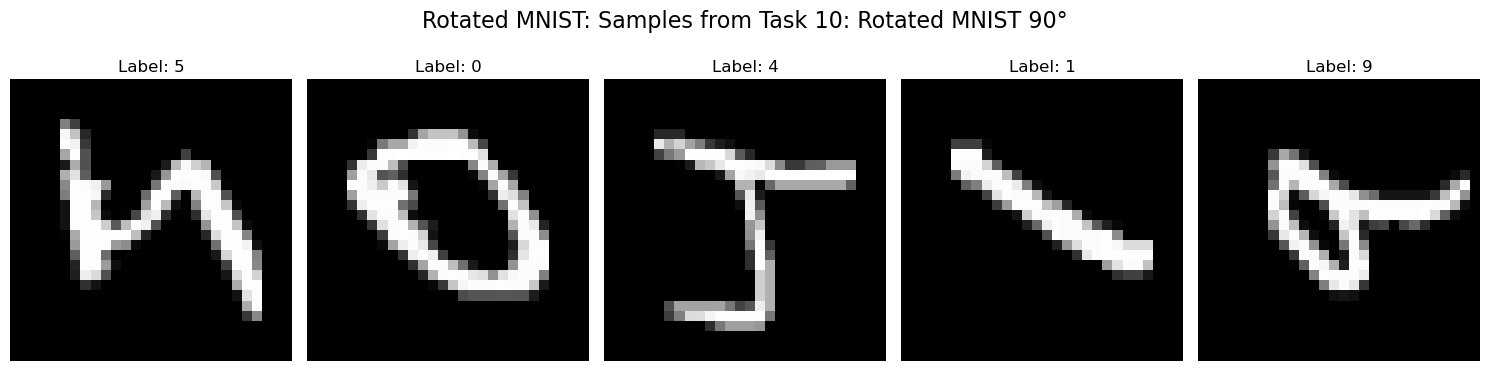

In [69]:
def create_rotated_mnist(task_id, base_angle=0):
    rotation_angle = base_angle + 10 * (task_id - 1)  # Fixed rotation for task
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle=rotation_angle))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Generate ten tasks of Rotated MNIST
tasks = [
    Task(
        name=f"Task {i}: Rotated MNIST {10 * (i - 1)}°",
        train=create_rotated_mnist(i)[0],
        test=create_rotated_mnist(i)[1]
    )
    for i in range(1, 11)
]

# Visualize samples from each task
for task in tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Rotated MNIST: Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()